# Cointegration Trading Strategy for Cryto Pairs

In [ ]:
%pip install ccxt
%pip install h5py

## 1. Imports and Setup

In [1]:
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import h5py
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt

### Setup

In [2]:
print(ccxt.exchanges)

exchange = ccxt.binance() # Set to Binance Exchange

ticker = exchange.fetch_ticker("BTC/USDT")

current_price = ticker["ask"]

print(f"The current price of BTC is {current_price} USDT")

['ace', 'alpaca', 'ascendex', 'bequant', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bingx', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'bybit', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinsph', 'coinspot', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'exmo', 'fmfwio', 'gate', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'kraken', 'krakenfutures', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'lbank2', 'luno', 'lykke', 'mercado', 'mexc', 'mexc3', 'ndax', 'novadax', 'oceanex', 'okcoin', 'okex', 'okex5', 'okx', 'paymium'

## 2. Obtaining Data

OHLC Data of last 24 hours

In [ ]:
yesterday_time = (
    int((datetime.utcnow() - timedelta(hours=24)).timestamp()) * 1000
)  # time 24 hours ago in milliseconds
since_time = (
    int((datetime.utcnow() - timedelta(minutes=440)).timestamp()) * 1000
)  # time since 1000 minutes from 24 hours ago in milliseconds

OHLC = pd.DataFrame(
    exchange.fetch_ohlcv(
        symbol="BTC/USDT",
        timeframe="1m",
        since=yesterday_time,
        limit=1000,  # max datapoints per call
    ),
    columns=["Time", "Open", "High", "Low", "Close", "Volume"],
)
OHLC_data_since = pd.DataFrame(
    exchange.fetch_ohlcv(
        symbol="BTC/USDT",
        timeframe="1m",
        since=since_time,
    ),
    columns=["Time", "Open", "High", "Low", "Close", "Volume"],
)

combined_OHLC = pd.concat([OHLC, OHLC_data_since], ignore_index=True)


combined_OHLC["Time"] = [
    datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
]
combined_OHLC.set_index("Time", inplace=True)

combined_OHLC

,Open,High,Low,Close,Volume
Time,,,,,
2023-10-22 23:27:00,30379.28,30396.78,30379.27,30390.82,23.24136
2023-10-22 23:28:00,30390.82,30418.83,30381.55,30412.75,64.70937
2023-10-22 23:29:00,30412.75,30438.41,30412.74,30429.00,61.22363
2023-10-22 23:30:00,30429.01,30435.80,30379.73,30381.78,32.08511
2023-10-22 23:31:00,30381.78,30412.28,30381.77,30412.28,52.27914
...,...,...,...,...,...
2023-10-23 19:22:00,33024.63,33090.00,32944.48,33083.31,174.52429
2023-10-23 19:23:00,33087.55,33281.94,33080.49,33207.25,246.71409
2023-10-23 19:24:00,33207.25,33251.49,32769.60,33106.69,439.03029


Plotting

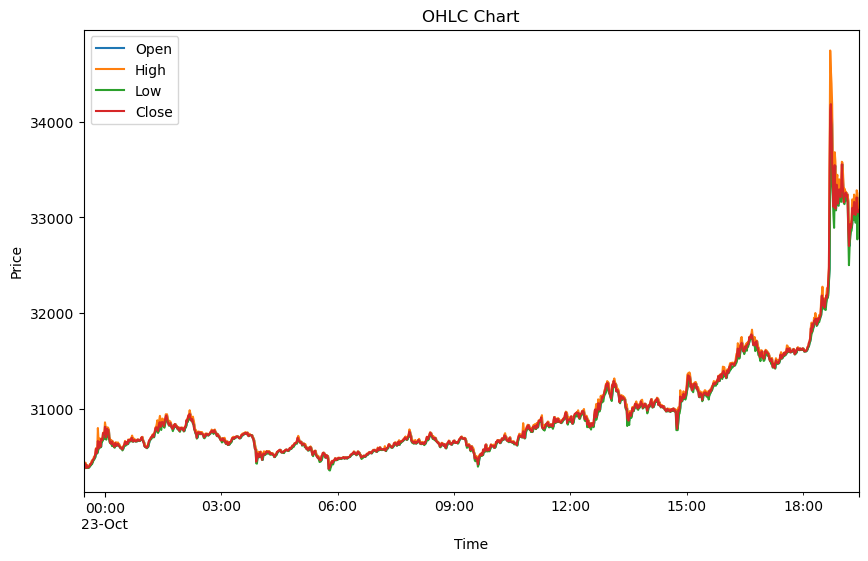

In [ ]:
combined_OHLC[["Open", "High", "Low", "Close"]].plot(style="-", figsize=(10, 6))

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("OHLC Chart")

plt.show()

OHLC Data Function

In [3]:
# def get_OHLC_data(symbol, timeframe, time, limit=1000):

#     since_time = datetime.utcnow() - timedelta(
#         days=time
#     )  # Length of time of data from the duration in days since today historically (could change to hours if wanted)

#     combined_OHLC = pd.DataFrame(
#         columns=["Time", "Open", "High", "Low", "Close", "Volume"]
#     )

#     while (
#         since_time < datetime.utcnow()
#     ):  # Looping in increments of limited 1000 calls until since_time reaches the current time
#         current_since_time = int(since_time.timestamp()) * 1000

#         OHLC_data = pd.DataFrame(
#             exchange.fetch_ohlcv(
#                 symbol=symbol,
#                 timeframe=timeframe,
#                 since=current_since_time,
#                 limit=limit,
#             ),
#             columns=["Time", "Open", "High", "Low", "Close", "Volume"],
#         )

#         combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

#         since_time += timedelta(
#             minutes=(limit * int(timeframe[:-1]))
#         )  # Increment by limit minutes

#     combined_OHLC["Time"] = [
#         datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
#     ]
#     combined_OHLC.set_index("Time", inplace=True)

#     return combined_OHLC
def get_OHLC_data(symbol, timeframe, time, limit=1000):
    since_time = datetime.utcnow() - timedelta(days=time)
    ohlc_list = []

    while since_time < datetime.utcnow():
        current_since_time = int(since_time.timestamp()) * 1000
        
        # Fetch OHLCV data from the exchange
        OHLC_data = pd.DataFrame(
            exchange.fetch_ohlcv(
                symbol=symbol,
                timeframe=timeframe,
                since=current_since_time,
                limit=limit,
            ),
            columns=["Time", "Open", "High", "Low", "Close", "Volume"],
        )

        if OHLC_data.empty:
            break  # Stop if no more data is fetched

        ohlc_list.append(OHLC_data)
        
        # Update since_time to be based on the last timestamp fetched, avoiding overlaps
        last_timestamp = OHLC_data['Time'].iloc[-1] / 1000  # Last timestamp in seconds
        since_time = datetime.fromtimestamp(last_timestamp) + timedelta(seconds=1)

    if ohlc_list:
        combined_OHLC = pd.concat(ohlc_list, ignore_index=True)
        combined_OHLC["Time"] = [
            datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
        ]
        combined_OHLC.set_index("Time", inplace=True)
        return combined_OHLC
    else:
        return pd.DataFrame(columns=["Time", "Open", "High", "Low", "Close", "Volume"])

# Example
symbol = "BTC/USDT"
timeframe = "1d"
time = 365*5  # Number of days since now

OHLC_data = get_OHLC_data(symbol, timeframe, time)
OHLC_data

,Open,High,Low,Close,Volume
Time,,,,,
2019-10-04 20:00:00,8137.09,8183.41,8012.98,8126.19,21907.615564
2019-10-05 20:00:00,8127.55,8153.87,7785.00,7854.25,34676.104049
2019-10-06 20:00:00,7855.30,8299.92,7762.00,8190.09,52202.072297
2019-10-07 20:00:00,8190.82,8325.00,8088.75,8168.39,35452.657423
2019-10-08 20:00:00,8170.79,8670.00,8115.00,8560.74,55038.704378
...,...,...,...,...,...
2024-09-26 20:00:00,65173.99,66498.00,64819.90,65769.95,22048.804870
2024-09-27 20:00:00,65769.95,66260.00,65422.23,65858.00,9127.233160
2024-09-28 20:00:00,65858.00,66076.12,65432.00,65602.01,8337.741110


Data Quality Checker

In [19]:
def check_data_quality(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Check for duplicates
    duplicates = df.duplicated().sum()
    duplicate_rows = None
    if duplicates != 0:
        duplicate_rows = df[df.duplicated()]
        duplicate_rows = (
            duplicate_rows.groupby(list(df)).apply(lambda x: tuple(x.index)).tolist()
        )

    return {
        "Missing Values": missing_values,
        "Duplicates": duplicate_rows,
    }

Data Check for OHLC Data

In [20]:
quality_report = check_data_quality(OHLC_data)

print("Data Quality Report:")
for check, result in quality_report.items():
    print(f"\n{check}:\n{result}")

Data Quality Report:

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicates:
None


Test if function works for a basic data set with duplicates

In [ ]:
data = {
    "A": [1, 4, 1, 7, 10, 4, 1],
    "B": [2, 5, 2, 8, 11, 5, 2],
    "C": [3, 6, 3, 9, 12, 6, 3],
}

df = pd.DataFrame(data)

check_data_quality(df)

{'Missing Values': A    0
 B    0
 C    0
 dtype: int64,
 'Duplicates': [(2, 6), (5,)]}

Data pulling and compression for BTC

In [4]:
def get_all_OHLC_data(symbol, timeframe, limit=1000):
    combined_OHLC = pd.DataFrame(
        columns=["Time", "Open", "High", "Low", "Close", "Volume"]
    )

    while True:  # Continue fetching data until there is no more historical data
        if combined_OHLC.empty:
            since_time = datetime.utcnow() - timedelta(
                days=365 * 10
            )  # Start fetching data from 10 years ago
        else:
            since_time = datetime.fromtimestamp(
                combined_OHLC["Time"].iloc[-1] / 1000
            ) + timedelta(minutes=limit * int(timeframe[:-1]))

        current_since_time = int(since_time.timestamp()) * 1000

        OHLC_data = pd.DataFrame(
            exchange.fetch_ohlcv(
                symbol=symbol,
                timeframe=timeframe,
                since=current_since_time,
                limit=limit,
            ),
            columns=["Time", "Open", "High", "Low", "Close", "Volume"],
        )

        if len(OHLC_data) == 0:
            break  # Break the loop if no more data is available
        
        if not OHLC_data.dropna(how='all').empty:
            combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

    combined_OHLC["Time"] = [
        datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
    ]
    combined_OHLC.set_index("Time", inplace=True)

    return combined_OHLC


symbol = "BTC/USDT"
timeframe = "1h"

all_BTC_OHLC_data = get_all_OHLC_data(symbol, timeframe)
all_BTC_OHLC_data

C:\Users\wsq\AppData\Local\Temp\ipykernel_14392\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


,Open,High,Low,Close,Volume
Time,,,,,
2017-08-17 00:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 01:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 02:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 03:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 04:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2024-10-01 13:00:00,62448.00,62448.00,61092.00,62151.99,5545.712410
2024-10-01 14:00:00,62152.00,62440.00,61859.57,61987.99,1708.277370
2024-10-01 15:00:00,61987.98,62091.29,61610.71,61755.99,1598.407770


#### Conversion to HDF

In [ ]:
import h5py

symbol = "BTC/USDT"


def HDF5_converter(dataset, symbol):
    with h5py.File(
        "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
        "w",
    ) as hdf:
        group = hdf.create_group(
            "Token_Warehouse"
        )  # Outermost group for all potential tokens
        symbol_group = group.create_group(
            f"{symbol}_group"
        )  # Subgroup for each token due to splitting datetime and OHLC data

        datetime_index_np = dataset.index.values.astype(
            h5py.opaque_dtype(dataset.index.dtype)
        )

        symbol_group.create_dataset(
            "datetime_index",
            data=datetime_index_np,
            compression="gzip",
            compression_opts=9,
        )

        symbol_group.create_dataset(
            "symbol", data=dataset, compression="gzip", compression_opts=9
        )


HDF5_converter(all_BTC_OHLC_data, symbol)

with h5py.File(
    "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
    "r",
) as hdf:
    datetime_index = pd.to_datetime(
        hdf["Token_Warehouse"][f"{symbol}_group"]["datetime_index"][:]
    )

    data = hdf["Token_Warehouse"][f"{symbol}_group"]["symbol"][:]

    read_data = pd.DataFrame(
        data, index=datetime_index, columns=all_BTC_OHLC_data.columns
    )

    print("Read Data:")
    print(read_data)

Read Data:
                         Open      High       Low     Close       Volume
2017-08-17 00:00:00   4261.48   4313.62   4261.32   4308.83    47.181009
2017-08-17 01:00:00   4308.83   4328.69   4291.37   4315.32    23.234916
2017-08-17 02:00:00   4330.29   4345.45   4309.37   4324.35     7.229691
2017-08-17 03:00:00   4316.62   4349.99   4287.41   4349.99     4.443249
2017-08-17 04:00:00   4333.32   4377.85   4333.32   4360.69     0.972807
...                       ...       ...       ...       ...          ...
2023-11-20 21:00:00  37600.61  37649.44  37419.57  37452.34  1203.934890
2023-11-20 22:00:00  37452.33  37555.99  37399.99  37464.86   827.177770
2023-11-20 23:00:00  37464.86  37480.17  37388.00  37389.98   439.333590
2023-11-21 00:00:00  37389.99  37398.81  37316.00  37355.89   676.296470
2023-11-21 01:00:00  37355.90  37411.10  37322.00  37375.09   505.493320

[53914 rows x 5 columns]


Mutiple token data fetcher

In [ ]:
def get_mutiple_all_OHLC_data(symbols, timeframe, limit=1000):
    all_combined_OHLC = {}

    for symbol in symbols:
        combined_OHLC = pd.DataFrame(
            columns=["Time", "Open", "High", "Low", "Close", "Volume"]
        )

        while True:  # Continue fetching data until there is no more historical data
            if combined_OHLC.empty:
                since_time = datetime.utcnow() - timedelta(
                    days=365 * 10
                )  # Start fetching data from 10 years ago
            else:
                since_time = datetime.fromtimestamp(
                    combined_OHLC["Time"].iloc[-1] / 1000
                ) + timedelta(minutes=limit * int(timeframe[:-1]))

            current_since_time = int(since_time.timestamp()) * 1000

            OHLC_data = pd.DataFrame(
                exchange.fetch_ohlcv(
                    symbol=symbol,
                    timeframe=timeframe,
                    since=current_since_time,
                    limit=limit,
                ),
                columns=["Time", "Open", "High", "Low", "Close", "Volume"],
            )

            if len(OHLC_data) == 0:
                break  # Break the loop if no more data is available

            combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)

        combined_OHLC["Time"] = [
            datetime.fromtimestamp(float(time) / 1000) for time in combined_OHLC["Time"]
        ]
        combined_OHLC.set_index("Time", inplace=True)

        all_combined_OHLC[symbol] = combined_OHLC

    return all_combined_OHLC


# Example usage for fetching data for 10 coins
symbols = [
    "BTC/USDT",
    "ETH/USDT",
    "BNB/USDT",
    "XRP/USDT",
    "SOL/USDT",
    "ADA/USDT",
    "DOGE/USDT",
    "TRX/USDT",
    "LINK/USDT",
    "AVAX/USDT",
]
timeframe = "1m"

all_coins_data = get_mutiple_all_OHLC_data(symbols, timeframe)

Multiple token converter

In [ ]:
def HDF5_converter(
    all_datasets,
    output_path="/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
):
    with h5py.File(output_path, "w") as hdf:
        group = hdf.create_group(
            "Token_Warehouse"
        )  # Outermost group for all potential tokens

        for symbol, dataset in all_datasets.items():
            symbol_group = group.create_group(
                f"{symbol}_group"
            )  # Subgroup for each token due to splitting datetime and OHLC data

            # Convert the datetime index to a NumPy array with opaque dtype
            datetime_index_np = dataset.index.values.astype(
                h5py.opaque_dtype(dataset.index.dtype)
            )

            # Save the datetime index as a separate dataset
            symbol_group.create_dataset(
                "datetime_index",
                data=datetime_index_np,
                compression="gzip",
                compression_opts=9,
            )

            # Save the main dataset
            symbol_group.create_dataset(
                "symbol", data=dataset.values, compression="gzip", compression_opts=9
            )


HDF5_converter(all_coins_data)

Basic Test

In [ ]:
with h5py.File(
    "/Users/wsq/Desktop/Jupyter/minute-data-fetcher/h5_compressed_data_warehouse.h5",
    "r",
) as hdf:
    print("File Structure:")
    print(list(hdf.keys()))

File Structure:
['Token_Warehouse']


In [ ]:
with h5py.File(
    '/Users/wsq/Desktop/Jupyter/minute-data-fetcher"/h5_compressed_data_warehouse.h5',
    "r",
) as hdf:
    if "Token_Warehouse" in hdf:
        print("'Token_Warehouse' group exists.")
        symbol_group = hdf["Token_Warehouse"]["BTC/USDT_group"]
        if "symbol" in symbol_group:
            print("'symbol' dataset exists.")
        else:
            print("'symbol' dataset does not exist.")
    else:
        print("'Token_Warehouse' group does not exist.")

'Token_Warehouse' group exists.
'symbol' dataset exists.


## 3. Utilizing Token Warehouse for Pairs Trading Strategy

#### ETH and BTC

##### ETH and BTC Plot for Time Series of Minute Data

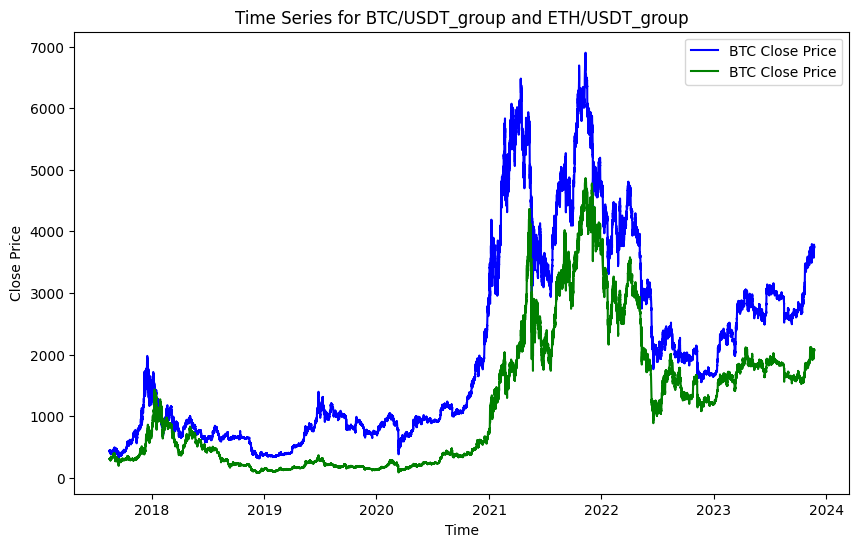

In [28]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt

token_1 = "BTC/USDT_group"
token_2 = "ETH/USDT_group"

with h5py.File("h5_compressed_data_warehouse.h5", "r") as hdf:
    BTC_data = hdf[f"/Token_Warehouse/{token_1}"]
    ETH_data = hdf[f"/Token_Warehouse/{token_2}"]

    datetime_index_np = BTC_data["datetime_index"][:]

    BTC_symbol_data = BTC_data["symbol"][:]
    ETH_symbol_data = ETH_data["symbol"][:]

    # Convert the opaque dtype back to datetime
    datetime_index = pd.to_datetime(datetime_index_np, unit="ns")

    # Creating a DataFrame
    df1 = pd.DataFrame(
        BTC_symbol_data,
        index=datetime_index,
        columns=["Open", "High", "Low", "Close", "Volume"],
    )
    df2 = pd.DataFrame(
        ETH_symbol_data,
        index=datetime_index,
        columns=["Open", "High", "Low", "Close", "Volume"],
    )

    # Plotting the time series line graph
    plt.figure(figsize=(10, 6))
    plt.plot(
        df1.index, df1["Close"] / 10, label="BTC Close Price", color="blue"
    )  # Scaled BTC close prices down by a factor of 10 to make the relationship more evident
    plt.plot(df2.index, df2["Close"], label="BTC Close Price", color="green")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.title(f"Time Series for {token_1} and {token_2}")
    plt.legend()
    plt.show()

Function to make opening h5 easier

In [30]:
def process_h5_file_close_data(file_path, group_path):

    with h5py.File(file_path, "r") as hdf:
        # Access the necessary datasets
        datetime_index = hdf[f"{group_path}/datetime_index"][:]
        close_prices = hdf[f"{group_path}/symbol"][:, 3]

        # Create a DataFrame
        df = pd.DataFrame(
            close_prices,
            index=pd.to_datetime(datetime_index, unit="ns"),
            columns=["Close"],
        )

    return df


eth = process_h5_file_close_data(
    "h5_compressed_data_warehouse.h5", "Token_Warehouse/ETH/USDT_group"
)


btc = process_h5_file_close_data(
    "h5_compressed_data_warehouse.h5", "Token_Warehouse/BTC/USDT_group"
)
btc

,Close
2017-08-17 00:00:00,4261.48
2017-08-17 00:01:00,4261.48
2017-08-17 00:02:00,4280.56
2017-08-17 00:03:00,4261.48
2017-08-17 00:04:00,4261.48
...,...
2023-11-23 05:32:00,37507.92
2023-11-23 05:33:00,37501.10
2023-11-23 05:34:00,37486.00
2023-11-23 05:35:00,37460.02


Testing and Training data with a 20/80 split where training is the most recent data and further data processing

In [31]:
from sklearn.model_selection import train_test_split

btc_train, btc_test = train_test_split(btc, test_size=0.2, shuffle=False)

eth_train, eth_test = train_test_split(eth, test_size=0.2, shuffle=False)

eth_train_returns = eth_train["Close"] / eth_train["Close"].shift(1) * 100

eth_train_returns = np.log(eth_train_returns).dropna()

btc_train_returns = btc_train["Close"] / btc_train["Close"].shift(1) * 100

btc_train_returns = np.log(btc_train_returns).dropna()

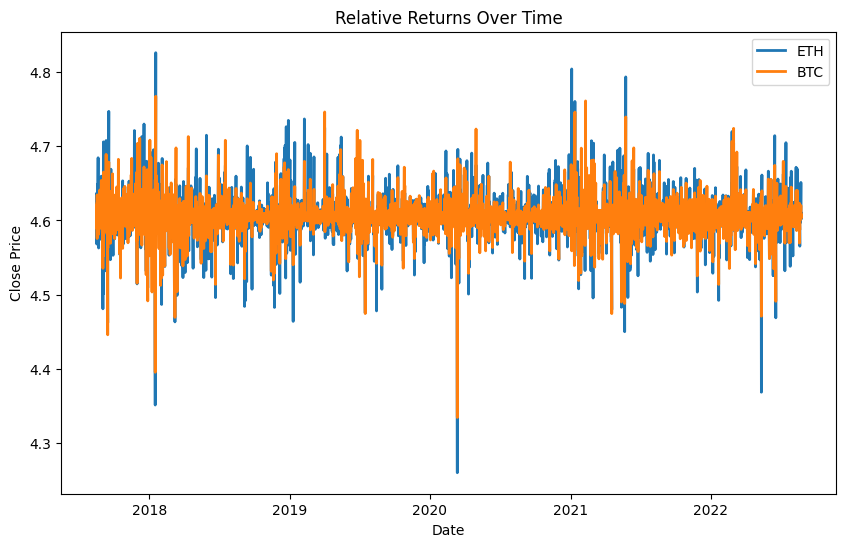

In [32]:
plt.figure(figsize=(10, 6))

# Plot ETH Close values
plt.plot(eth_train_returns.index, eth_train_returns.values, label="ETH", linewidth=2)
plt.plot(btc_train_returns.index, btc_train_returns.values, label="BTC", linewidth=2)

# Set labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Relative Returns Over Time")

# Add legend
plt.legend()

# Show the plot
plt.show()

Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

df_returns = pd.DataFrame({"ETH": eth_train_returns, "BTC": btc_train_returns})

x_train = df_returns[["BTC"]]
y_train = df_returns["ETH"]

model = LinearRegression()

model.fit(x_train, y_train)

model.score(x_train, y_train)  # R^2

coef = model.coef_[0]

intercept = model.intercept_

print(intercept)
print(coef)

errors = y_train - (coef * x_train["BTC"] + intercept)

0.8082721361871856
0.8244859926773564


Charting the errors

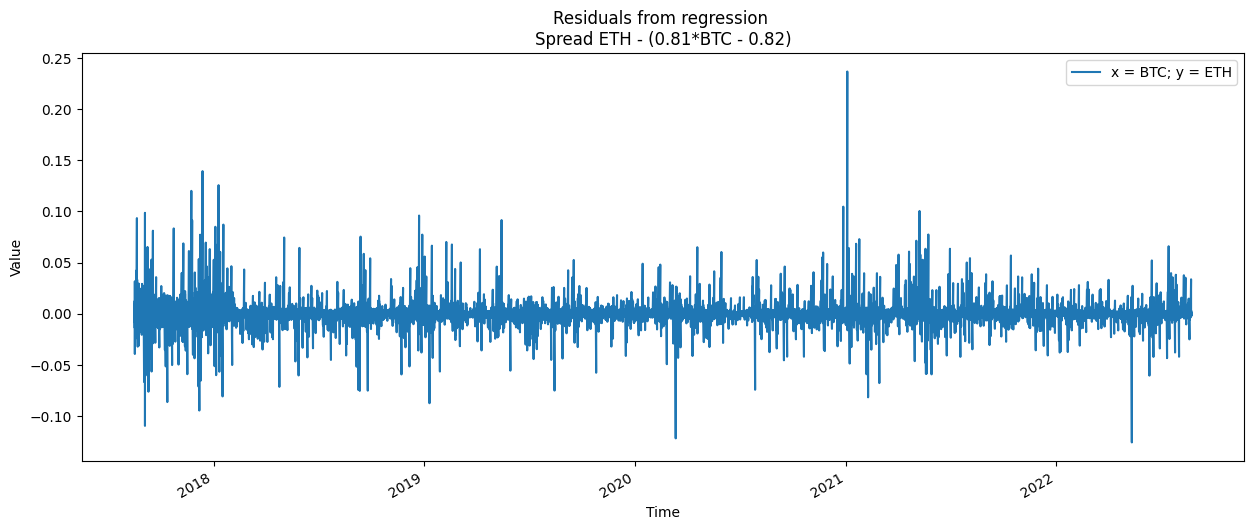

In [14]:
plt.figure(figsize=(15, 6))
errors.plot(label="x = BTC; y = ETH")
plt.title("Residuals from regression \nSpread ETH - (0.81*BTC - 0.82)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

Dickey Fuller test (Testing for unit root in AR model (Stationarity))

In [34]:
from statsmodels.tsa.stattools import adfuller


dftest = adfuller(errors, maxlag=1)
dfoutput = pd.Series(
    dftest[0:4],
    index=[
        "Test Stat",
        "P-Val",
        "#Lags Used",
        "#Obs Used",
    ],
)
critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

print(
    f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
)

Dikey Fuller Results:
Test Stat    -9.344814e+02
P-Val         0.000000e+00
#Lags Used    1.000000e+00
#Obs Used     1.317597e+06
dtype: float64 

Dikey Fuller Critical Values:
1%    -3.430355
5%    -2.861542
10%   -2.566771
dtype: float64


###### This means that we reject the null at all significant values that the model is non-stationary

Z-Score and Signals starting with 1.2 and -1.2 Thresholds

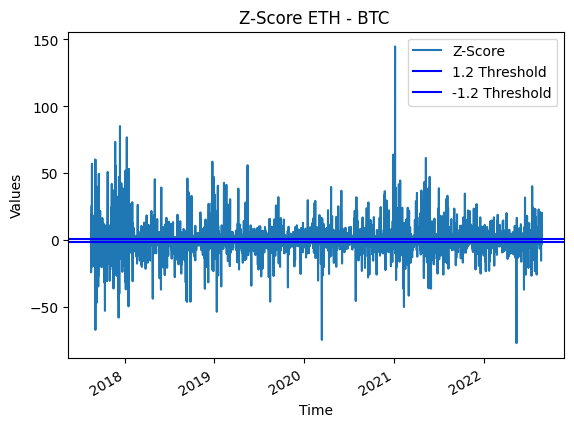

In [16]:
spread = errors
zscore = (spread - np.mean(spread)) / np.std(spread)
zscore.plot(label="Z-Score")
plt.title("Z-Score ETH - BTC ")
plt.xlabel("Time")
plt.ylabel("Values")
plt.axhline(y=1.2, color="b", label="1.2 Threshold")
plt.axhline(y=-1.2, color="b", label="-1.2 Threshold")
plt.legend()
plt.show()

Backtest on training data

In [17]:
# Long the spread: short ETH, long BTC
# Short the spread: long ETH, short BTC


signal_entry = 1.2
signal_exit = 0


btest = pd.DataFrame()
btest["ETH"] = eth_train["Close"]
btest["BTC"] = btc_train["Close"]

btest = btest.iloc[1:]

btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

Backtest

In [38]:
spread_side = None
counter = -1
backtest_result = []

for time, signals_stock in btest.iterrows():
    counter += 1
    eth_, btc_, short_sig, short_ex, long_sig, long_ex = signals_stock

    if spread_side is None:
        eth_return = 0
        btc_return = 0
        backtest_result.append([time, eth_return, btc_return, spread_side])

        if short_sig:
            spread_side = "short"
        elif long_sig:
            spread_side = "long"

    elif spread_side == "long":
        eth_return = btest["ETH"].iloc[counter] / btest["ETH"].iloc[counter - 1] - 1.0
        btc_return = btest["BTC"].iloc[counter] / btest["BTC"].iloc[counter - 1] - 1.0
        backtest_result.append([time, eth_return, -btc_return, spread_side])

        if long_ex:
            spread_side = None

    elif spread_side == "short":
        eth_return = btest["ETH"].iloc[counter] / btest["ETH"].iloc[counter - 1] - 1.0
        btc_return = btest["BTC"].iloc[counter] / btest["BTC"].iloc[counter - 1] - 1.0
        backtest_result.append([time, -eth_return, btc_return, spread_side])

        if short_ex:
            spread_side = None



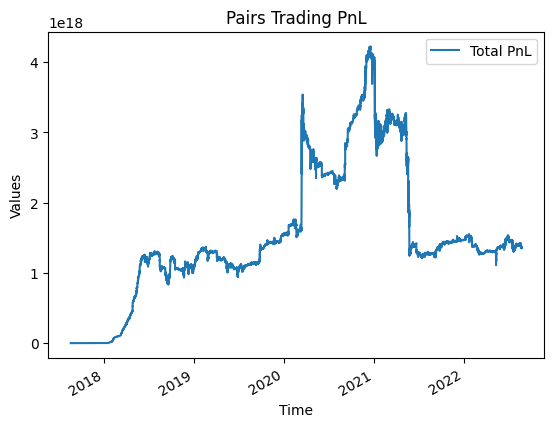

In [39]:
backtest_pd = pd.DataFrame(backtest_result)
backtest_pd.columns = ["Date", "ETH", "BTC", "Side"]
backtest_pd["ETH PnL"] = np.cumprod(backtest_pd["ETH"] + 1)
backtest_pd["BTC PnL"] = np.cumprod(backtest_pd["BTC"] + 1)
backtest_pd["Total PnL"] = (backtest_pd["BTC PnL"] + backtest_pd["ETH PnL"]) / 2
backtest_pd.index = backtest_pd["Date"]

total_return_train = backtest_pd[["Total PnL"]]
backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss")
plt.title("Pairs Trading PnL")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

### Backtest on Test Data

In [40]:
eth_test_returns = eth_test["Close"] / eth_test["Close"].shift(1) * 100

eth_test_returns = np.log(eth_test_returns).dropna()

btc_test_returns = btc_test["Close"] / btc_test["Close"].shift(1) * 100

btc_test_returns = np.log(btc_test_returns).dropna()


df_test_returns = pd.DataFrame({"ETH": eth_test_returns, "BTC": btc_test_returns})

x_test = df_test_returns[["BTC"]]
y_test = df_test_returns["ETH"]

errors_test = y_test - (coef * x_test["BTC"] + intercept)

spread = errors_test
zscore = (spread - np.mean(spread)) / np.std(spread)

In [41]:
signal_entry = 1.2
signal_exit = 0


btest = pd.DataFrame()
btest["ETH"] = eth_test["Close"]
btest["BTC"] = btc_test["Close"]

btest = btest.iloc[1:]

btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)


spread_side = None
counter = -1
backtest_result = []
indicator = 0
for time, signals_stock in btest.iterrows():
    counter += 1
    eth_, btc_, short_sig, short_ex, long_sig, long_ex = signals_stock

    if spread_side == None:
        eth_return = 0
        btc_return = 0
        backtest_result.append([time, eth_return, btc_return, spread_side])

        if short_sig == True:
            spread_side = "short"
        elif long_sig == True:
            spread_side = "long"

    elif spread_side == "long":
        eth_return = btest["ETH"].iloc[counter] / btest["ETH"].iloc[counter - 1] - 1.0
        btc_return = btest["BTC"].iloc[counter] / btest["BTC"].iloc[counter - 1] - 1.0
        backtest_result.append([time, eth_return, -btc_return, spread_side])

        if long_ex:
            spread_side = None

    elif spread_side == "short":
        eth_return = btest["ETH"].iloc[counter] / btest["ETH"].iloc[counter - 1] - 1.0
        btc_return = btest["BTC"].iloc[counter] / btest["BTC"].iloc[counter - 1] - 1.0
        backtest_result.append([time, -eth_return, btc_return, spread_side])

        if short_ex == True:
            spread_side = None


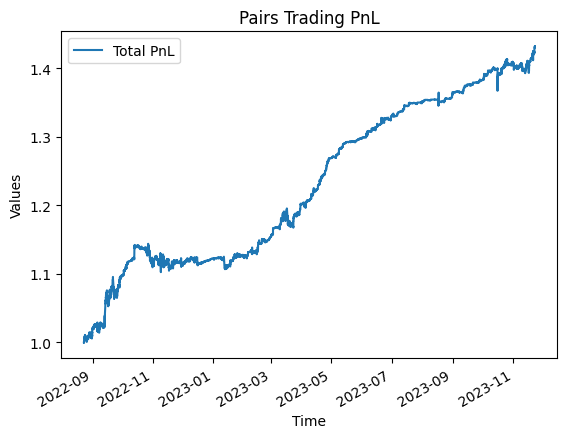

,Date,ETH,BTC,Side,ETH PnL,BTC PnL,Total PnL
Date,,,,,,,
2022-08-23 06:47:00,2022-08-23 06:47:00,0.000000,0.000000,None,1.000000,1.000000,1.000000
2022-08-23 06:48:00,2022-08-23 06:48:00,0.000000,0.000000,None,1.000000,1.000000,1.000000
2022-08-23 06:49:00,2022-08-23 06:49:00,0.000000,0.000000,None,1.000000,1.000000,1.000000
2022-08-23 06:50:00,2022-08-23 06:50:00,-0.000852,0.000425,long,0.999148,1.000425,0.999786
2022-08-23 06:51:00,2022-08-23 06:51:00,-0.000853,0.000844,long,0.998296,1.001269,0.999782
...,...,...,...,...,...,...,...
2023-11-23 05:32:00,2023-11-23 05:32:00,0.000000,0.000000,None,1.308770,1.555551,1.432161
2023-11-23 05:33:00,2023-11-23 05:33:00,0.000000,0.000000,None,1.308770,1.555551,1.432161
2023-11-23 05:34:00,2023-11-23 05:34:00,0.000000,0.000000,None,1.308770,1.555551,1.432161


In [42]:
backtest_pd = pd.DataFrame(backtest_result)
backtest_pd.columns = ["Date", "ETH", "BTC", "Side"]
backtest_pd["ETH PnL"] = np.cumprod(backtest_pd["ETH"] + 1)
backtest_pd["BTC PnL"] = np.cumprod(backtest_pd["BTC"] + 1)
backtest_pd["Total PnL"] = (backtest_pd["BTC PnL"] + backtest_pd["ETH PnL"]) / 2
backtest_pd.index = backtest_pd["Date"]

backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss for Test Data")
plt.title("Pairs Trading PnL")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

backtest_pd

### 3.1. Generalizing the process 

In [8]:
def process_returns(data, value: str):
    """Process PD DF with Close values column to get log relative returns of Close values to return a new dataframe"""
    asset_returns = data[value] / data[value].shift(1) * 100

    asset_returns = np.log(asset_returns).dropna()

    return asset_returns


def regress_for_values(Y_coin_returns, X_coin_returns):
    """Linear Regression for"""
    df_returns = pd.DataFrame({"Y": Y_coin_returns, "X": X_coin_returns})

    x_train = df_returns[["X"]]
    y_train = df_returns["Y"]

    model = LinearRegression()

    model.fit(x_train, y_train)

    coef = model.coef_[0]

    intercept = model.intercept_

    errors = y_train - (coef * x_train["X"] + intercept)

    return errors


def regress_for_values_test(y_test_ret, x_test_ret, y_train_ret, x_train_ret):
    """Helper for getting errors of test data given training data"""
    df_returns = pd.DataFrame({"Y": y_train_ret, "X": x_train_ret})

    x_train = df_returns[["X"]]
    y_train = df_returns["Y"]

    model = LinearRegression()

    model.fit(x_train, y_train)

    coef = model.coef_[0]

    intercept = model.intercept_

    df_test_returns = pd.DataFrame({"Y": y_test_ret, "X": x_test_ret})

    x_test = df_test_returns[["X"]]
    y_test = df_test_returns["Y"]

    errors_test = y_test - (coef * x_test["X"] + intercept)

    return errors_test


def adfuller_test(errors, sig_lvl="1%"):
    """adfuller test to test wether or not their exists cointegration at the 1% level. True if test stat > 1% significance critical value"""
    dftest = adfuller(errors, maxlag=1)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Stat",
            "P-Val",
            "#Lags Used",
            "#Obs Used",
        ],
    )
    critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

    return dfoutput["Test Stat"] < critical_values[sig_lvl]


def backtest(errors, signal_entry, signal_exit, X_data, Y_data, value):
    """Backtesting Process"""
    spread = errors
    zscore = (spread - np.mean(spread)) / np.std(spread)

    btest = pd.DataFrame()
    btest["Y"] = Y_data[value]
    btest["X"] = X_data[value]

    btest = btest.iloc[1:]

    btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
    btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

    btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
    btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

    spread_side = None
    counter = -1
    backtest_result = []
    indicator = 0
    for time, signals_stock in btest.iterrows():
        counter += 1
        y_, x_, short_sig, short_ex, long_sig, long_ex = signals_stock

        if spread_side == None:
            y_return = 0
            x_return = 0
            backtest_result.append([time, y_return, x_return, spread_side])

            if short_sig == True:
                spread_side = "short"
            elif long_sig == True:
                spread_side = "long"

        elif spread_side == "long":
            y_return = btest["Y"].iloc[counter] / btest["Y"].iloc[counter - 1] - 1.0
            x_return = btest["X"].iloc[counter] / btest["X"].iloc[counter - 1] - 1.0
            backtest_result.append([time, y_return, -x_return, spread_side])

            if long_ex == True:
                spread_side = None

        elif spread_side == "short":
            y_return = btest["Y"].iloc[counter] / btest["Y"].iloc[counter - 1] - 1.0
            x_return = btest["X"].iloc[counter] / btest["X"].iloc[counter - 1] - 1.0
            backtest_result.append([time, -y_return, x_return, spread_side])

            if short_ex == True:
                spread_side = None

    return backtest_result


def show_PnL(backtest_result):
    """Showing PnL result"""
    backtest_pd = pd.DataFrame(backtest_result)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2
    backtest_pd.index = backtest_pd["Date"]

    backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss for Data")
    plt.title("Pairs Trading PnL")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()


# need to split into training and testing sets before this


def pair_trade_result(
    data_x_train,
    data_y_train,
    data_x_test,
    data_y_test,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Full Function from start to finish"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    x_returns_test = process_returns(data_x_test, value)
    y_returns_test = process_returns(data_y_test, value)

    errors_train = regress_for_values(y_returns, x_returns)
    errors_test = regress_for_values_test(
        y_returns_test, x_returns_test, y_returns, x_returns
    )

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    results_test = backtest(
        errors_test, signal_entry, signal_exit, data_x_test, data_y_test, value
    )

    print("Training PnL")
    show_PnL(results_train)

    print("Test PnL")
    show_PnL(results_test)


def final_profit(data_x_train,data_y_train,value="Close",signal_entry=1.2,signal_exit=0,sig_level="1%",):
    """Get final profit given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    return backtest_pd["Total PnL"].iloc[-1]


def std_dev_returns(
    data_x_train,
    data_y_train,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Get sharpe ratio given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y PnL", "X PnL", "Side"]
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    backtest_pd["Total PnL"].iloc[-1]

    return backtest_pd["Total PnL"].std()

Trying ETH, BTC day data

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


Training PnL


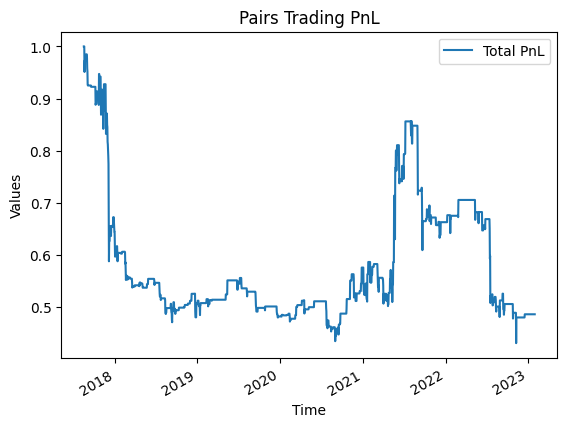

Test PnL


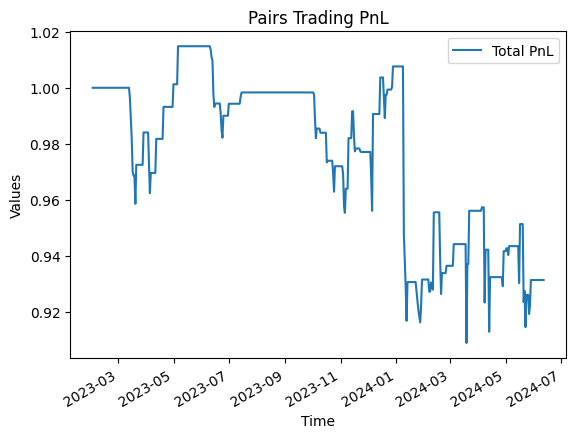

In [53]:
timeframe = "1d"

all_BTC_Day_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Day_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_1, btc_test_1 = train_test_split(
    all_BTC_Day_Data, test_size=0.2, shuffle=False
)

eth_train_1, eth_test_1 = train_test_split(
    all_ETH_Day_Data, test_size=0.2, shuffle=False
)

pair_trade_result(btc_train_1, eth_train_1, btc_test_1, eth_test_1)

Profit vs Entry Levels

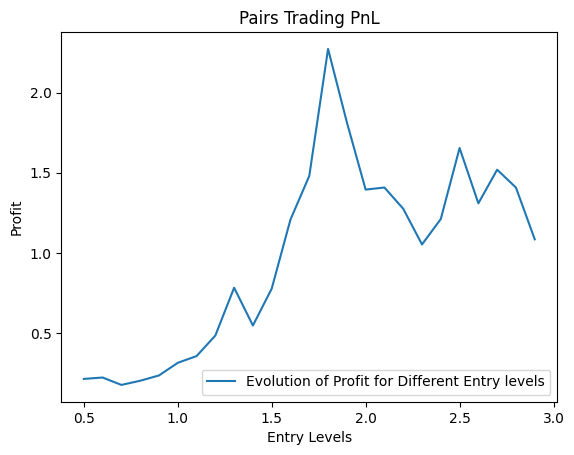

In [54]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_1, eth_train_1, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

Sharpe Ratio vs Entry Levels

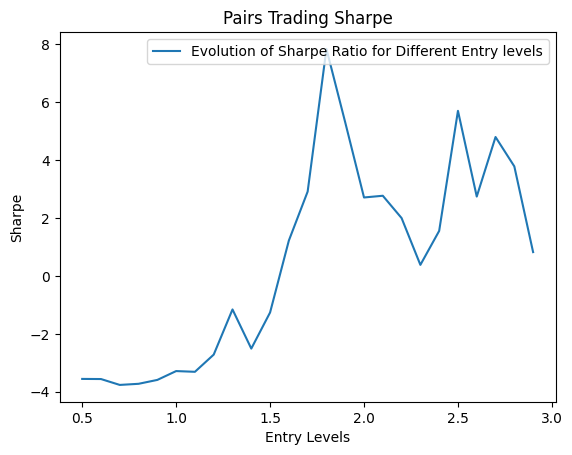

,Sharpe,Std_d
Num,,
2.9,0.823099,0.103728
2.8,3.786810,0.107713
2.7,4.801559,0.108114
2.6,2.743255,0.112868
2.5,5.706300,0.114642
2.4,1.556443,0.136206
2.3,0.382332,0.139473
2.2,1.999869,0.137981
2.1,2.771092,0.147242


In [57]:
final_df = pd.DataFrame(columns=["Num", "Sharpe", "Std_d"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_1, eth_train_1, signal_entry=num) - 1
    # profit = profit / len(btc_train_1) * 365
    std_dev = std_dev_returns(btc_train_1, eth_train_1, signal_entry=num) * sqrt(365)
    sharpe = profit / std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index()

final_df.set_index("Num", inplace=True)

final_df["Sharpe"].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel("Entry Levels")
plt.ylabel("Sharpe")
plt.legend()
plt.show()

final_df

Trying ETH, BTC hour data

C:\Users\wsq\AppData\Local\Temp\ipykernel_596\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_596\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


Training PnL


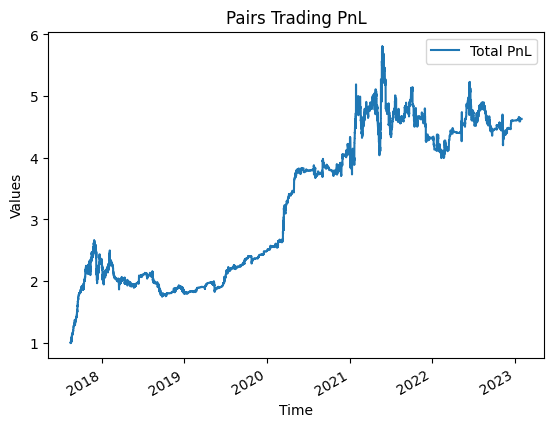

Test PnL


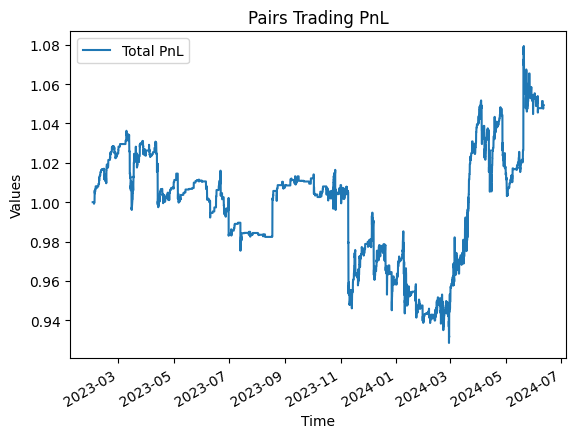

In [58]:
timeframe = "1h"

all_BTC_Hour_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Hour_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_2, btc_test_2 = train_test_split(
    all_BTC_Hour_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2 = train_test_split(
    all_ETH_Hour_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2

pair_trade_result(btc_train_2, eth_train_2, btc_test_2, eth_test_2)

Profit vs Entry

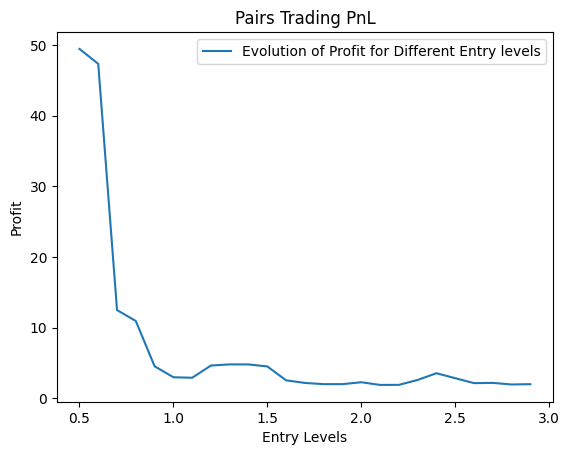

,Profit
Num,
2.9,1.984763
2.8,1.943770
2.7,2.169236
2.6,2.135105
2.5,2.834806
2.4,3.536551
2.3,2.586396
2.2,1.888794
2.1,1.881468


In [59]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_2, eth_train_2, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

final_profits

Sharpe vs Entry

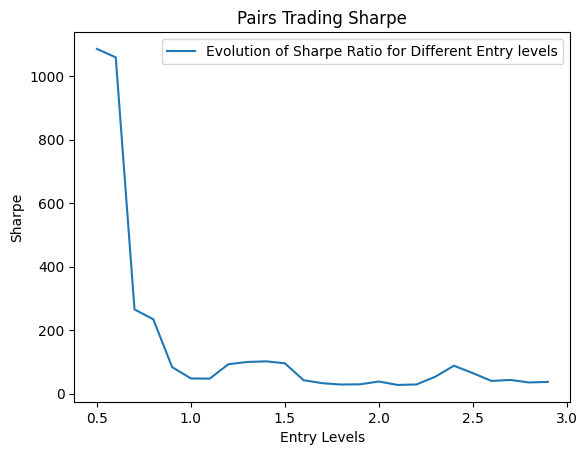

,Sharpe,Std_d
Num,,
2.9,37.220407,0.026458
2.8,35.371665,0.026682
2.7,43.391474,0.026946
2.6,40.146341,0.028274
2.5,64.949744,0.028250
2.4,88.060891,0.028805
2.3,53.166661,0.029838
2.2,29.018824,0.030628
2.1,27.654493,0.031874


In [60]:
final_df = pd.DataFrame(columns=["Num", "Sharpe", "Std_d"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_2, eth_train_2, signal_entry=num) - 1
    # profit = profit / len(btc_train_2) * 365
    std_dev = std_dev_returns(btc_train_2, eth_train_2, signal_entry=num) * sqrt(365)
    sharpe = profit / std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index()

final_df.set_index("Num", inplace=True)

final_df["Sharpe"].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel("Entry Levels")
plt.ylabel("Sharpe")
plt.legend()
plt.show()

final_df

### Minute Data

Profit vs Entry

C:\Users\wsq\AppData\Local\Temp\ipykernel_672\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_672\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


Training PnL


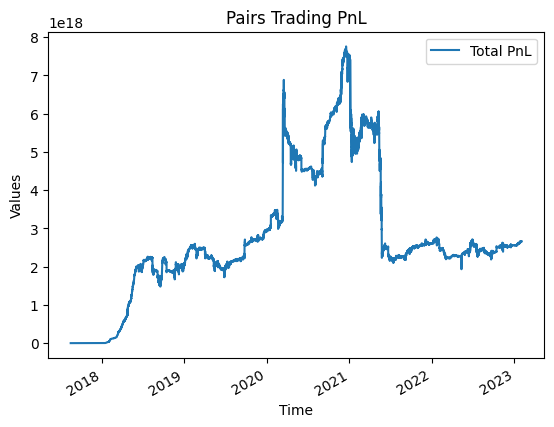

Test PnL


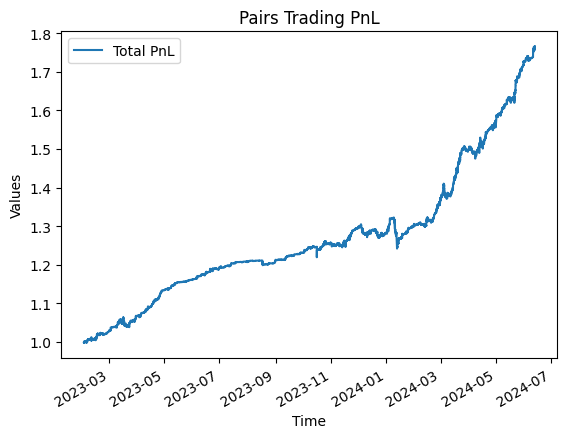

In [11]:
timeframe = "1m"

all_BTC_Min_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Min_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_3, btc_test_3 = train_test_split(
    all_BTC_Min_Data, test_size=0.2, shuffle=False
)

eth_train_3, eth_test_3 = train_test_split(
    all_ETH_Min_Data, test_size=0.2, shuffle=False
)

pair_trade_result(btc_train_3, eth_train_3, btc_test_3, eth_test_3)

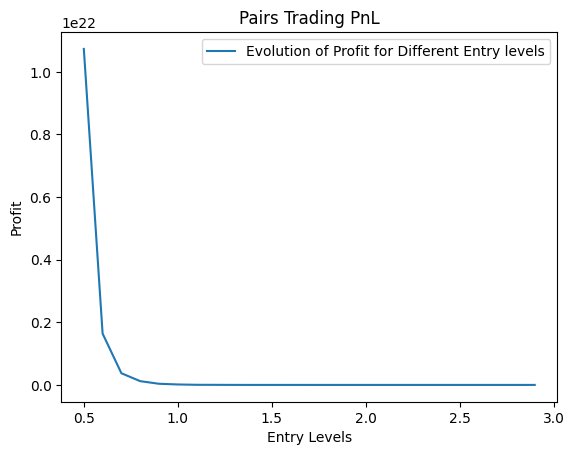

In [13]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_3, eth_train_3, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

Sharpe vs Entry

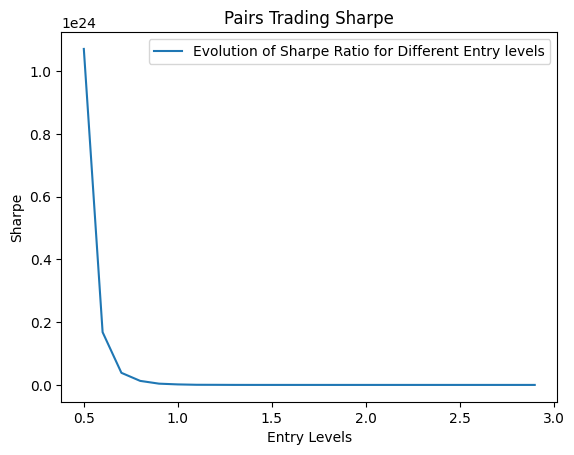

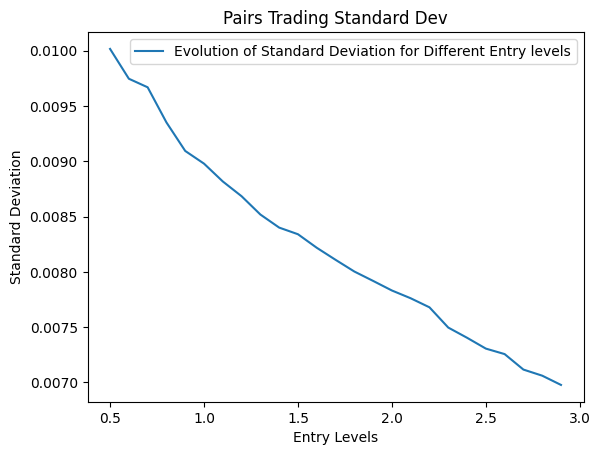

,Sharpe,Std_d
Num,,
2.9,2.732439e+14,0.006978
2.8,4.365822e+14,0.007062
2.7,9.992891e+14,0.007117
2.6,2.060359e+15,0.007257
2.5,3.727178e+15,0.007307
2.4,9.709293e+15,0.007405
2.3,1.670168e+16,0.007497
2.2,3.289029e+16,0.007680
2.1,4.984297e+16,0.007762


In [15]:
final_df = pd.DataFrame(columns=['Num', 'Sharpe', 'Std_d'])
for num in range(5, 30):
    num = num/10
    profit = final_profit(btc_train_3, eth_train_3, signal_entry=num) - 1
    # profit = (profit/len(btc_train_3) * 365)
    std_dev = std_dev_returns(btc_train_3, eth_train_3, signal_entry=num) * sqrt(365)
    sharpe = profit/std_dev
    final_df.loc[-1] = [num, sharpe, std_dev]
    final_df.index = final_df.index + 1
    final_df = final_df.sort_index() 

final_df.set_index('Num', inplace=True)

final_df['Sharpe'].plot(label="Evolution of Sharpe Ratio for Different Entry levels")
plt.title("Pairs Trading Sharpe")
plt.xlabel('Entry Levels')
plt.ylabel('Sharpe')
plt.legend()
plt.show()

final_df['Std_d'].plot(label="Evolution of Standard Deviation for Different Entry levels")
plt.title("Pairs Trading Standard Dev")
plt.xlabel('Entry Levels')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

final_df

### General Transaction Cost Inclusion

Since our PnLs seem incredibly implausible for low exit/entry thresholds likely coming from excessively frequent trading, incorporating transation costs should make it more realistic

In [5]:
def backtest_new(errors, signal_entry, signal_exit, X_data, Y_data, value):
    """Backtesting process with transaction costs as a 10 basis points deducted per trade"""
    spread = errors
    zscore = (spread - np.mean(spread)) / np.std(spread)

    btest = pd.DataFrame()
    btest["Y"] = Y_data[value]
    btest["X"] = X_data[value]

    btest = btest.iloc[1:]

    btest["Short Signal"] = (zscore > signal_entry) & (zscore.shift(1) < signal_entry)
    btest["Short Exit"] = (zscore < signal_exit) & (zscore.shift(1) > signal_exit)

    btest["Long Signal"] = (zscore < -signal_entry) & (zscore.shift(1) > -signal_entry)
    btest["Long Exit"] = (zscore > -signal_exit) & (zscore.shift(1) < -signal_exit)

    count = 0
    spread_side = None
    counter = -1
    backtest_result = []
    indicator = 0
    for time, signals_stock in btest.iterrows():
        counter += 1
        y_, x_, short_sig, short_ex, long_sig, long_ex = signals_stock

        if spread_side == None:
            y_return = 0
            x_return = 0
            backtest_result.append([time, y_return, x_return, spread_side])

            if short_sig == True:
                spread_side = "short"
                # Deduct transaction cost
                y_return = -0.0005
                x_return = -0.0005
                backtest_result.append([time, y_return, x_return, spread_side])
            elif long_sig == True:
                spread_side = "long"
                y_return = -0.0005
                x_return = -0.0005
                backtest_result.append([time, y_return, x_return, spread_side])

        elif spread_side == "long":
            y_return = btest["Y"].iloc[counter] / btest["Y"].iloc[counter - 1] - 1.0
            x_return = btest["X"].iloc[counter] / btest["X"].iloc[counter - 1] - 1.0
            backtest_result.append([time, y_return, -x_return, spread_side])

            if long_ex == True:
                spread_side = None
                y_return = -0.0005
                x_return = -0.0005
                backtest_result.append([time, y_return, x_return, spread_side])

        elif spread_side == "short":
            y_return = btest["Y"].iloc[counter] / btest["Y"].iloc[counter - 1] - 1.0
            x_return = btest["X"].iloc[counter] / btest["X"].iloc[counter - 1] - 1.0
            backtest_result.append([time, -y_return, x_return, spread_side])

            if short_ex == True:
                spread_side = None
                y_return = -0.0005
                x_return = -0.0005
                backtest_result.append([time, y_return, x_return, spread_side])
                
    return backtest_result

def show_PnL(backtest_result):
    """Showing PnL result"""
    backtest_pd = pd.DataFrame(backtest_result)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2
    backtest_pd.index = backtest_pd["Date"]

    backtest_pd[["Total PnL"]].plot(label="Evolution of Profit and Loss for Data")
    plt.title("Pairs Trading PnL")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()
    #print(backtest_pd)

def pair_trade_result(
    data_x_train,
    data_y_train,
    data_x_test,
    data_y_test,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Full Function from start to finish"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    x_returns_test = process_returns(data_x_test, value)
    y_returns_test = process_returns(data_y_test, value)

    errors_train = regress_for_values(y_returns, x_returns)
    errors_test = regress_for_values_test(
        y_returns_test, x_returns_test, y_returns, x_returns
    )

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest_new(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    results_test = backtest_new(
        errors_test, signal_entry, signal_exit, data_x_test, data_y_test, value
    )

    print("Training PnL")
    show_PnL(results_train)

    print("Test PnL")
    show_PnL(results_test)


def final_profit(data_x_train,data_y_train,value="Close",signal_entry=1.2,signal_exit=0,sig_level="1%",):
    """Get final profit given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest_new(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y", "X", "Side"]
    backtest_pd["Y PnL"] = np.cumprod(backtest_pd["Y"] + 1)
    backtest_pd["X PnL"] = np.cumprod(backtest_pd["X"] + 1)
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    return backtest_pd["Total PnL"].iloc[-1]


def std_dev_returns(
    data_x_train,
    data_y_train,
    value="Close",
    signal_entry=1.2,
    signal_exit=0,
    sig_level="1%",
):
    """Get sharpe ratio given a signal entry value"""
    x_returns = process_returns(data_x_train, value)
    y_returns = process_returns(data_y_train, value)

    errors_train = regress_for_values(y_returns, x_returns)

    if adfuller_test(errors_train, sig_lvl=sig_level) is False:
        dftest = adfuller(errors_train, maxlag=1)
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Stat",
                "P-Val",
                "#Lags Used",
                "#Obs Used",
            ],
        )
        critical_values = pd.Series(dftest[4].values(), index=dftest[4].keys())

        print(
            f"Dikey Fuller Results:\n{dfoutput} \n\nDikey Fuller Critical Values:\n{critical_values}"
        )

        print(
            f"No cointegration exists for this asset pair at the {sig_level} significance level"
        )
        return

    results_train = backtest_new(
        errors_train, signal_entry, signal_exit, data_x_train, data_y_train, value
    )

    backtest_pd = pd.DataFrame(results_train)
    backtest_pd.columns = ["Date", "Y PnL", "X PnL", "Side"]
    backtest_pd["Total PnL"] = (backtest_pd["Y PnL"] + backtest_pd["X PnL"]) / 2

    backtest_pd["Total PnL"].iloc[-1]

    return backtest_pd["Total PnL"].std()


Redoing Hour and Minute Data for ETH BTC

C:\Users\wsq\AppData\Local\Temp\ipykernel_14392\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_14392\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


Training PnL


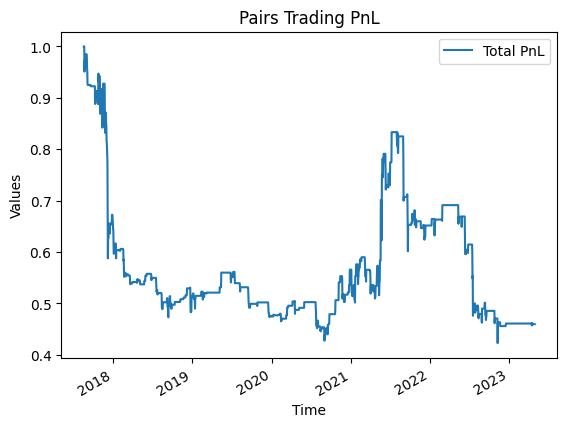

Test PnL


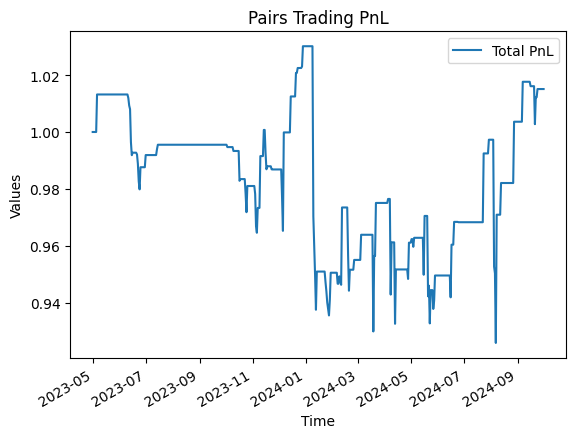

In [9]:
timeframe = "1h"

all_BTC_Hour_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Hour_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_2, btc_test_2 = train_test_split(
    all_BTC_Hour_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2 = train_test_split(
    all_ETH_Hour_Data, test_size=0.2, shuffle=False
)

eth_train_2, eth_test_2

pair_trade_result(btc_train_2, eth_train_2, btc_test_2, eth_test_2)

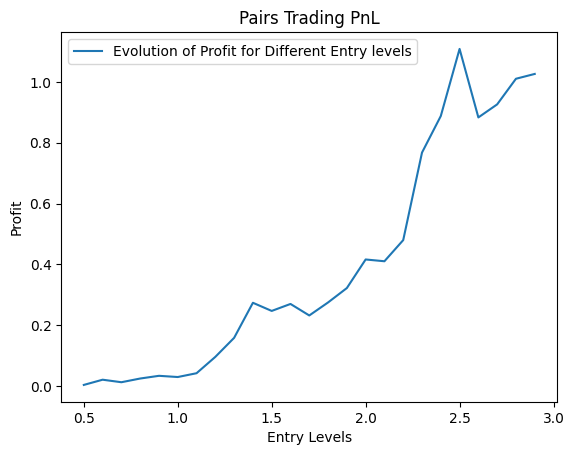

In [38]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 30):
    num = num / 10
    profit = final_profit(btc_train_2, eth_train_2, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

Minute Data

C:\Users\wsq\AppData\Local\Temp\ipykernel_13076\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)
C:\Users\wsq\AppData\Local\Temp\ipykernel_13076\660421190.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_OHLC = pd.concat([combined_OHLC, OHLC_data], ignore_index=True)


Training PnL


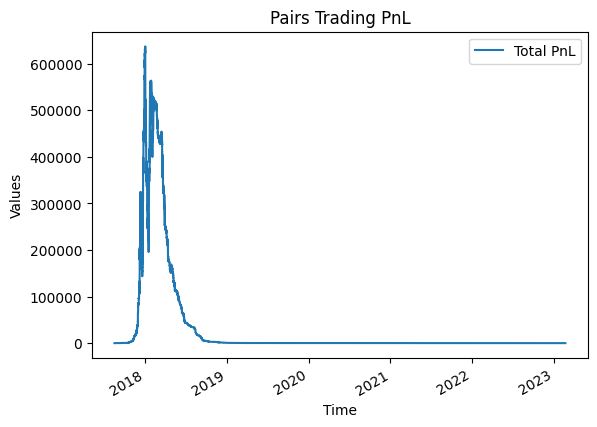

Test PnL


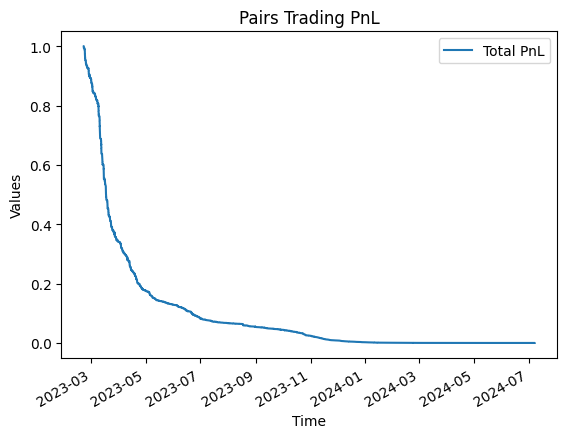

In [23]:
timeframe = "1m"

all_BTC_Min_Data = get_all_OHLC_data("BTC/USDT", timeframe)

all_ETH_Min_Data = get_all_OHLC_data("ETH/USDT", timeframe)

btc_train_3, btc_test_3 = train_test_split(
    all_BTC_Min_Data, test_size=0.2, shuffle=False
)

eth_train_3, eth_test_3 = train_test_split(
    all_ETH_Min_Data, test_size=0.2, shuffle=False
)

pair_trade_result(btc_train_3, eth_train_3, btc_test_3, eth_test_3)

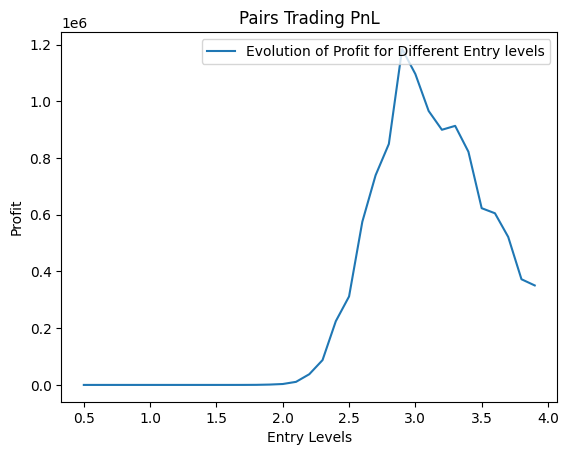

In [25]:
final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 40):
    num = num / 10
    profit = final_profit(btc_train_3, eth_train_3, signal_entry=num)
    final_profits.loc[-1] = [num, profit]
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

### Remarks

So key things to note so far:
1. BTC and ETH serve inherently different purposes and their primary source of "cointegration" likely lies in being the dominant tokens in the developing and high growth market (especially initally as seen in our evolution of profit graphs)
2. The timeframe of data which is used utilizes a lot of "polluted" data or data that is not reflective of the current market. Due to the initial high "inefficiency" market as well as the dynamic nature of the market, utilizing a lot of data from the past pollutes our dataset.
3. Utilizing such a huge dataset while involving polluted data will potentially cause our dickey fuller test to reject the null of non-stationarity even though in the present the difference in pairs may not be stationary in the present state of the market

To address the last two problems, a smaller and more recent dataset should be used to test for cointegration. For day data, we will do 5 years, hourly, the most recent year, and minute data, the most recent quarter.

## New pairs

Now that we have obtained a foundation we can apply this to more tokens within their respective groups to find "good" cointegration. Tokens will be split into 3 distinct groups. Furthermore, we can also add another group of tokens that do not fit in any of these catagories called memecoins. We will look at the top 50 coins on coinmarketcap.
1. Payment Tokens
2. Store of Value Tokens
3. Utility Tokens
4. Memecoins

### 1. Payment Tokens
BNB, XRP, TON, AVAX, BCH, LTC, XLM, MXR, CRO, IMX, INJ

### 2. Store of Value Tokens
BTC, LTC, OKB, FIL, LINK, AAVE

### 3. Utility Tokens
ETH, SOL, TON, ADA, TRX, AVAX, DOT, LINK, NEAR, MATIC, LEO, UNI, MXR, ETC, APT, FET, CRO, FIL, HBAR, STX, MNT, ATOM, TAO, VET, RNDR, MKR, ARB, SUI, AAVE, OP, OKB

### 4. Memecoins
DOGE, SHIB, PEPE, WIF, BONK

### Potential Pairs

1. BTC LTC
LTC inspired by BTC, Forked off of BTC, known as the silver to BTC's gold, both use proof of work, however, LTC is more payment than store of val in comp to BTC

2. LINK ETH
LINK deeply integrated with ETH, hosted on its platorm, provides data for ethereum based dAPPs

3. AAVE ETH
AAVE operates on ethereum blockchain, and the aave exchange offers access to ETH

4. UNI AAVE
Both underlying platforms to facilitate financial activity (lending and swapping), part of DeFi ecosystem ()

5. TON XRP
Fast low costs transactions, used for payments

6. AVAX ETH
Supporting dApps, AVAX goal is to improve on ethereum's cons

7. BTC BCH
Forked from BTC, have same supply cap, similar block time, same cryptography, PoW



#### BTC/BCH

Day Data

In [32]:
timeframe = "1d"

BTC_Day_Data = get_OHLC_data("BTC/USDT", timeframe, 365*4)

BCH_Day_Data = get_OHLC_data("BCH/USDT", timeframe, 365*4)

btc_train_1, btc_test_1 = train_test_split(
    BTC_Day_Data, test_size=0.2, shuffle=False
)

bch_train_1, bch_test_1 = train_test_split(
    BCH_Day_Data, test_size=0.2, shuffle=False
)

In [33]:
btc_train_1, bch_train_1

(                         Open      High       Low     Close        Volume
 Time                                                                     
 2020-10-03 20:00:00  10542.07  10696.87  10517.87  10666.63  23212.001595
 2020-10-04 20:00:00  10666.62  10798.00  10615.64  10792.21  34025.761653
 2020-10-05 20:00:00  10792.20  10800.00  10525.00  10599.66  48674.740471
 2020-10-06 20:00:00  10599.65  10681.87  10546.17  10666.39  32811.990279
 2020-10-07 20:00:00  10666.40  10950.00  10530.41  10925.57  51959.691572
 ...                       ...       ...       ...       ...           ...
 2023-12-09 19:00:00  43713.59  44049.00  43563.00  43789.51  18956.617580
 2023-12-10 19:00:00  43789.50  43804.50  40222.00  41253.40  76663.898040
 2023-12-11 19:00:00  41253.41  42104.12  40680.00  41492.39  42722.697730
 2023-12-12 19:00:00  41492.38  43475.20  40555.00  42869.03  45865.997730
 2023-12-13 19:00:00  42869.03  43420.00  41400.00  43022.26  42047.057090
 
 [1167 rows x 5 columns

In [22]:
quality_report = check_data_quality(bch_test_1)

print("Data Quality Report:")
for check, result in quality_report.items():
    print(f"\n{check}:\n{result}")

Data Quality Report:

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Duplicates:
None


Training PnL


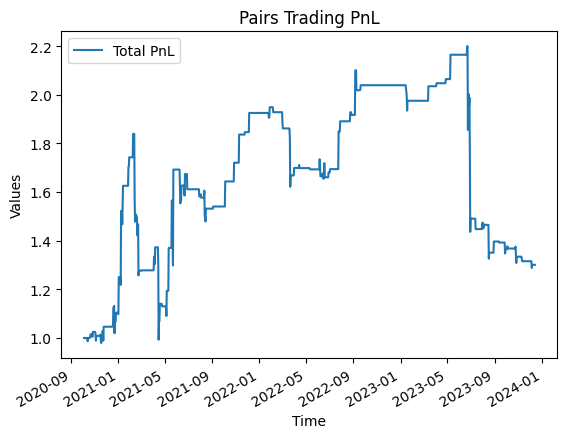

Test PnL


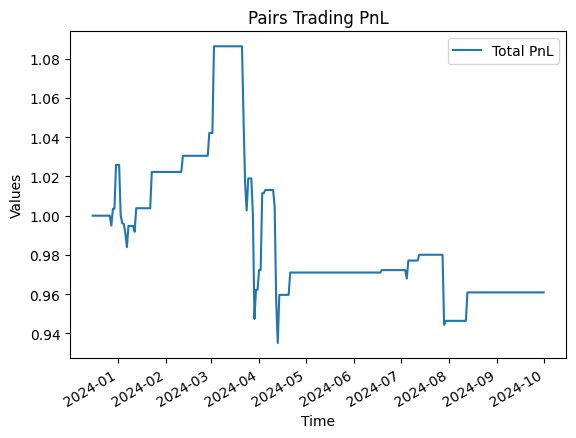

In [30]:
pair_trade_result(btc_train_1, bch_train_1, btc_test_1, bch_test_1)

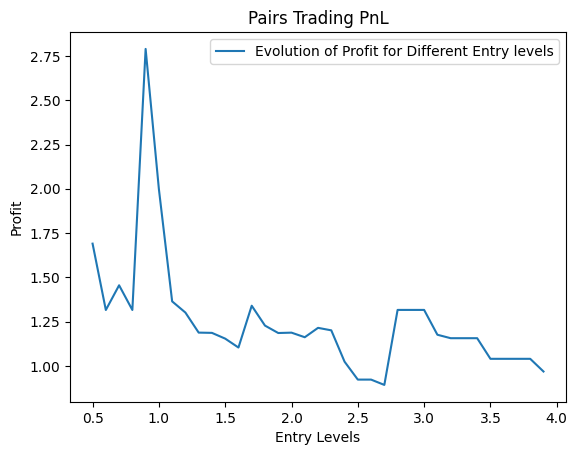

Training PnL


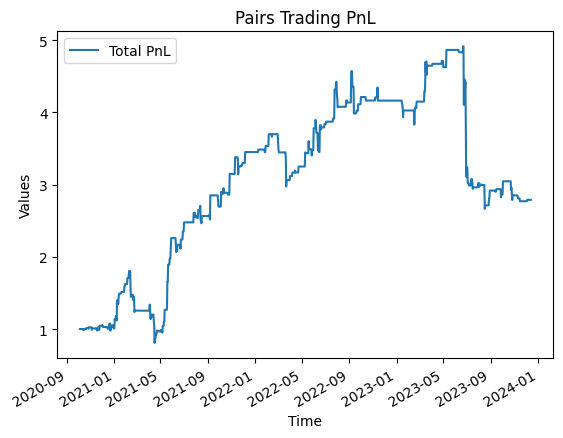

Test PnL


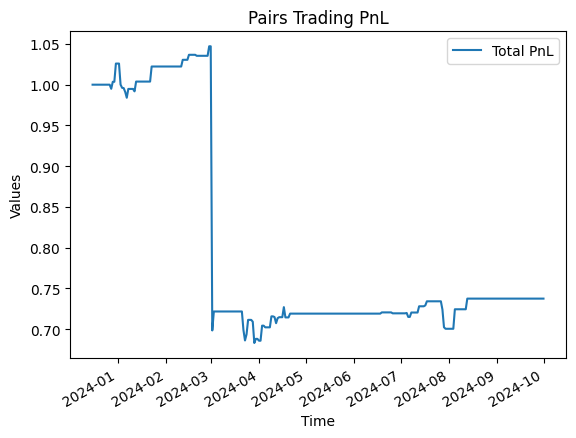

In [40]:
timeframe = "1d"

BTC_Day_Data = get_OHLC_data("BTC/USDT", timeframe, 365*4)

BCH_Day_Data = get_OHLC_data("BCH/USDT", timeframe, 365*4) # BCH data does not full go back 5 years

btc_train_1, btc_test_1 = train_test_split(
    BTC_Day_Data, test_size=0.2, shuffle=False
)

bch_train_1, bch_test_1 = train_test_split(
    BCH_Day_Data, test_size=0.2, shuffle=False
)

final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 40):
    num = num / 10
    profit = final_profit(btc_train_1, bch_train_1, signal_entry=num)
    final_profits.loc[-1] = [num, profit]   
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

best_num = final_profits["Profit"].idxmax()

pair_trade_result(btc_train_1, bch_train_1, btc_test_1, bch_test_1, signal_entry=best_num)

## Hour data

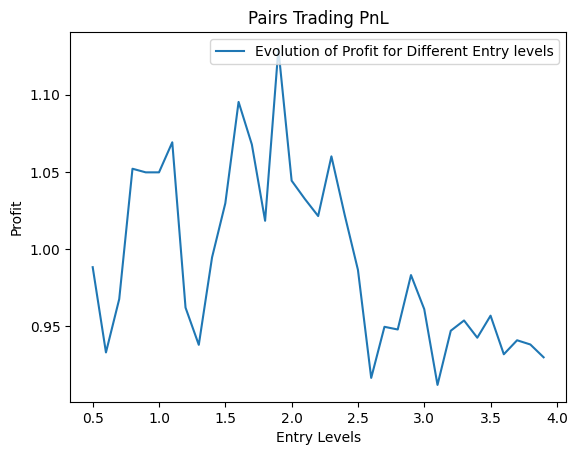

Training PnL


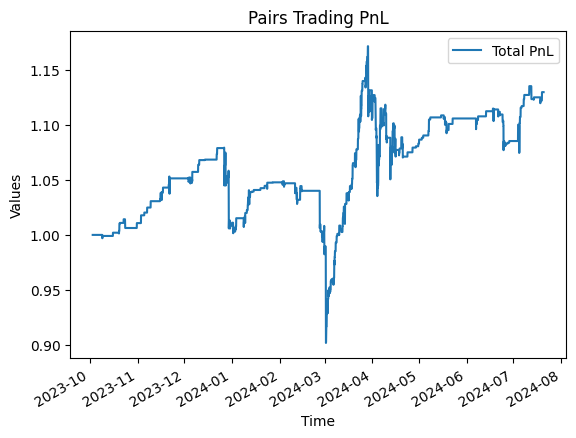

Test PnL


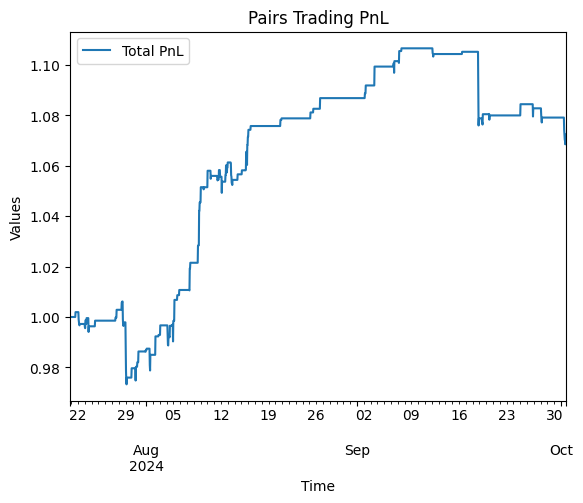

In [41]:
timeframe = "1h"

BTC_Day_Data = get_OHLC_data("BTC/USDT", timeframe, 365)

BCH_Day_Data = get_OHLC_data("BCH/USDT", timeframe, 365)

btc_train_1, btc_test_1 = train_test_split(
    BTC_Day_Data, test_size=0.2, shuffle=False
)

bch_train_1, bch_test_1 = train_test_split(
    BCH_Day_Data, test_size=0.2, shuffle=False
)

final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(5, 40):
    num = num / 10
    profit = final_profit(btc_train_1, bch_train_1, signal_entry=num)
    final_profits.loc[-1] = [num, profit]   
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

best_num = final_profits["Profit"].idxmax()

pair_trade_result(btc_train_1, bch_train_1, btc_test_1, bch_test_1, signal_entry=best_num)

## Min data

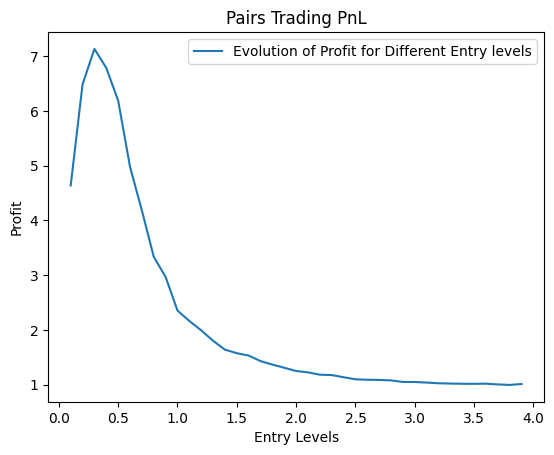

Training PnL


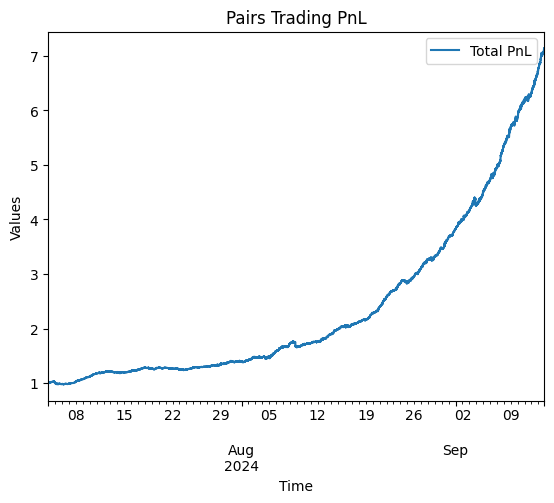

Test PnL


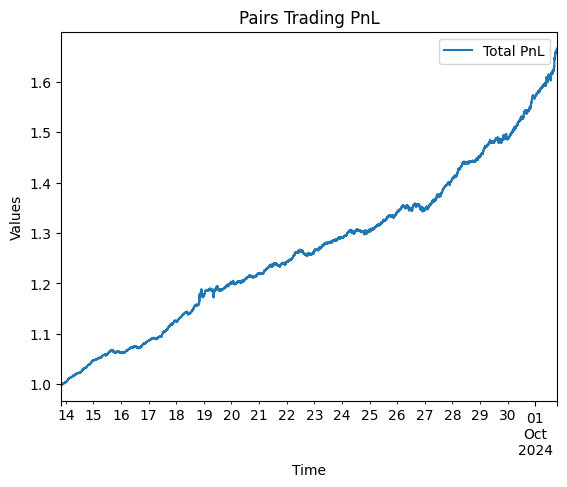

In [43]:
timeframe = "1m"

BTC_Day_Data = get_OHLC_data("BTC/USDT", timeframe, 90)

BCH_Day_Data = get_OHLC_data("BCH/USDT", timeframe, 90)

btc_train_1, btc_test_1 = train_test_split(
    BTC_Day_Data, test_size=0.2, shuffle=False
)

bch_train_1, bch_test_1 = train_test_split(
    BCH_Day_Data, test_size=0.2, shuffle=False
)

final_profits = pd.DataFrame(columns=["Num", "Profit"])
for num in range(1, 40):
    num = num / 10
    profit = final_profit(btc_train_1, bch_train_1, signal_entry=num)
    final_profits.loc[-1] = [num, profit]   
    final_profits.index = final_profits.index + 1
    final_profits = final_profits.sort_index()

final_profits.set_index("Num", inplace=True)

final_profits["Profit"].plot(label="Evolution of Profit for Different Entry levels")
plt.title("Pairs Trading PnL")
plt.xlabel("Entry Levels")
plt.ylabel("Profit")
plt.legend()
plt.show()

best_num = final_profits["Profit"].idxmax()

pair_trade_result(btc_train_1, bch_train_1, btc_test_1, bch_test_1, signal_entry=best_num)